# TEST 3: Noise Variation

## Setup the dataset

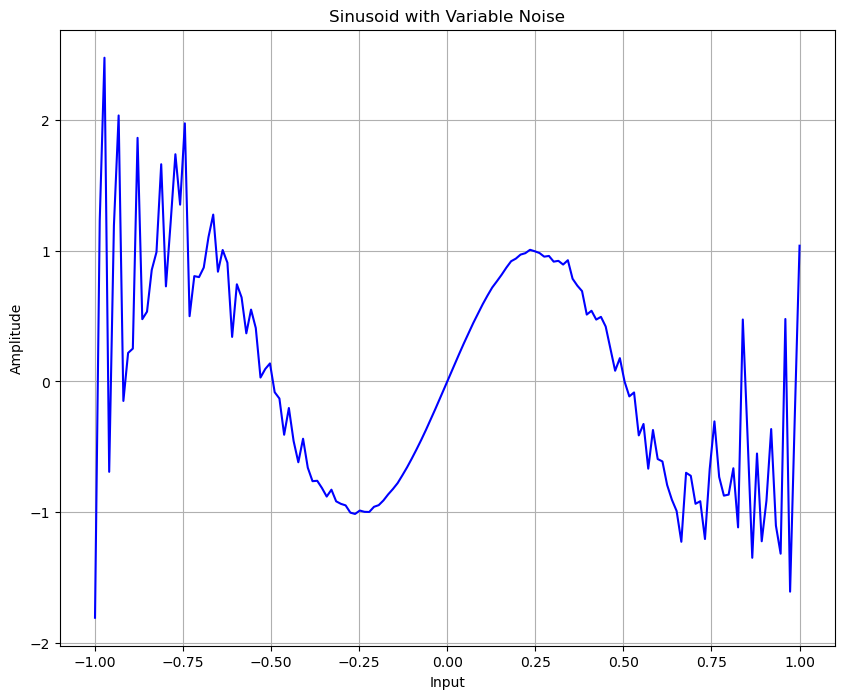

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# USER Parameters for the sinusoid
freq_sine = 1 # Hz
n_samples = 150

# Create input datasets and sine wave w/ noise variation
x_train = np.linspace(-1, 1, n_samples)
y_train = np.sin(2 * np.pi * freq_sine * x_train) + np.random.randn(n_samples) * (x_train ** 3)
x_test = np.linspace(-1.5, 1.5, 200)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, color='b')
plt.title('Sinusoid with Variable Noise')
plt.xlabel('Input')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Define and Fit the BLR Model

In [2]:
from sklearn.linear_model import BayesianRidge
import numpy as np

n_order = 5 # order for polynomial features

# Create datasets with polynomial features
x_train_blr = np.vander(x_train, n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin_noise = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
# blr_model_sin2.estimator.set_params(alpha_init=1.0, lambda_init=0.001) # Had no effect

# Fit the model
blr_model_sin_noise.fit(x_train_blr, y_train)

BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06)

## Make predictions with the BLR model and Plot it

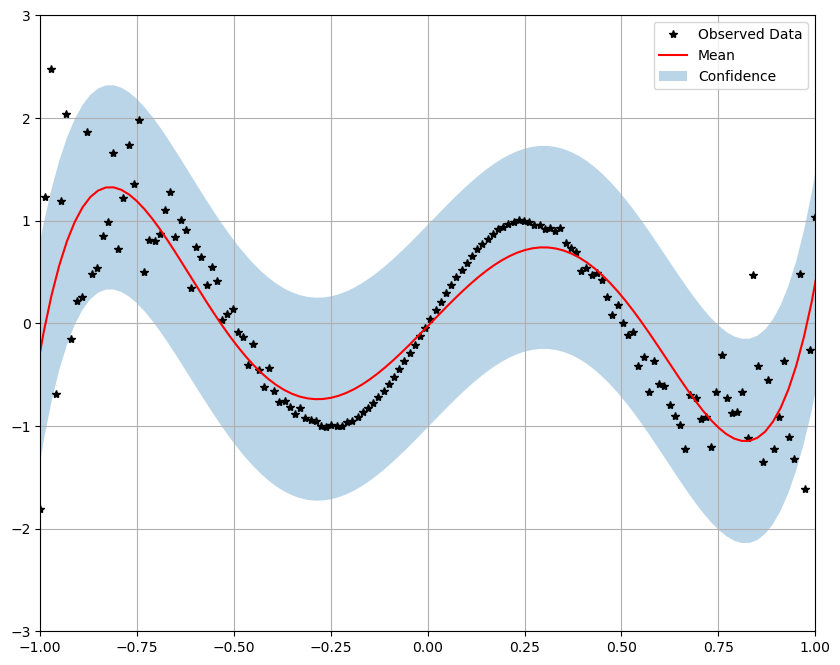

In [3]:
y_means, y_stds = blr_model_sin_noise.predict(x_test_blr, return_std=True)

# Plot 
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*') # Training data
plt.plot(x_test, y_means, 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means - 2 * y_stds, y_means + 2 * y_stds, alpha=0.3)
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.ylim([-3, 3])
plt.xlim([-1, 1])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [4]:
# Pass the test data through the model
print(f"Alpha (Estimated precision of the noise): {blr_model_sin_noise.alpha_}")
print(f"Lambda (Estimated precision of the weights): {blr_model_sin_noise.lambda_}")
print(f"Score (log marginal likelihood: {blr_model_sin_noise.scores_[-1]}")

Alpha (Estimated precision of the noise): 4.208744604250709
Lambda (Estimated precision of the weights): 0.011978485389250594
Score (log marginal likelihood: -128.30022937915416


## Setup Online Learning Variational GP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, 
                                                   inducing_points, 
                                                   variational_distribution, 
                                                   learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(torch.randn(25, 1), likelihood)

## Setup Train Dataset

In [ ]:
# USER Parameters for the sinusoid
freq_sine = 1 # Hz
n_samples = 150

# Create input datasets and sine wave w/ noise variation
x_train = np.linspace(-1, 1, n_samples)
y_train = np.sin(2 * np.pi * freq_sine * x_train) + np.random.randn(n_samples) * (x_train ** 3)

## Train GP Model

In [2]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.shape[0])

x_train_tens = torch.from_numpy(x_train).float()
y_train_tens = torch.from_numpy(y_train).float()
epochs = 500
for i in range(epochs + 1):
    optimizer.zero_grad()
    output = model(x_train_tens)
    loss = -mll(output, y_train_tens.squeeze())
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("Iteration: ", i, "\t Loss:", loss.item())

Iteration:  0 	 Loss: 1.7712823152542114
Iteration:  50 	 Loss: 0.8259521722793579
Iteration:  100 	 Loss: 0.7892059683799744
Iteration:  150 	 Loss: 0.7885507345199585
Iteration:  200 	 Loss: 0.7875214219093323
Iteration:  250 	 Loss: 0.7874358296394348
Iteration:  300 	 Loss: 0.7879033088684082
Iteration:  350 	 Loss: 0.7874178290367126
Iteration:  400 	 Loss: 0.7957980036735535
Iteration:  450 	 Loss: 0.7874443531036377
Iteration:  500 	 Loss: 0.7874176502227783


## Eval GP Model

In [3]:
model.eval()
likelihood.eval()

x_test = torch.linspace(-2, 2, 250).view(-1, 1)
with torch.no_grad():
    posterior = likelihood(model(x_test))
    mean = posterior.mean
    lower, upper = posterior.confidence_region()

## Update Model with new data

In [19]:
# Create new data
n_new_samples = 30
x_new = np.linspace(1, 1.5, n_new_samples)
y_new = np.sin(2 * np.pi * freq_sine * x_new) + np.random.normal(0, 0.5, n_new_samples) * (x_new ** 2)

x_new_tens = torch.from_numpy(x_new).float()
y_new_tens = torch.from_numpy(y_new).float()
updated_model = model.variational_strategy.get_fantasy_model(inputs=x_new_tens, targets=y_new_tens.squeeze())

with torch.no_grad():
    updated_posterior = updated_model.likelihood(updated_model(x_test))
    mean_updated = updated_posterior.mean
    lower_updated, upper_updated = updated_posterior.confidence_region()

## Plot GP Model Results

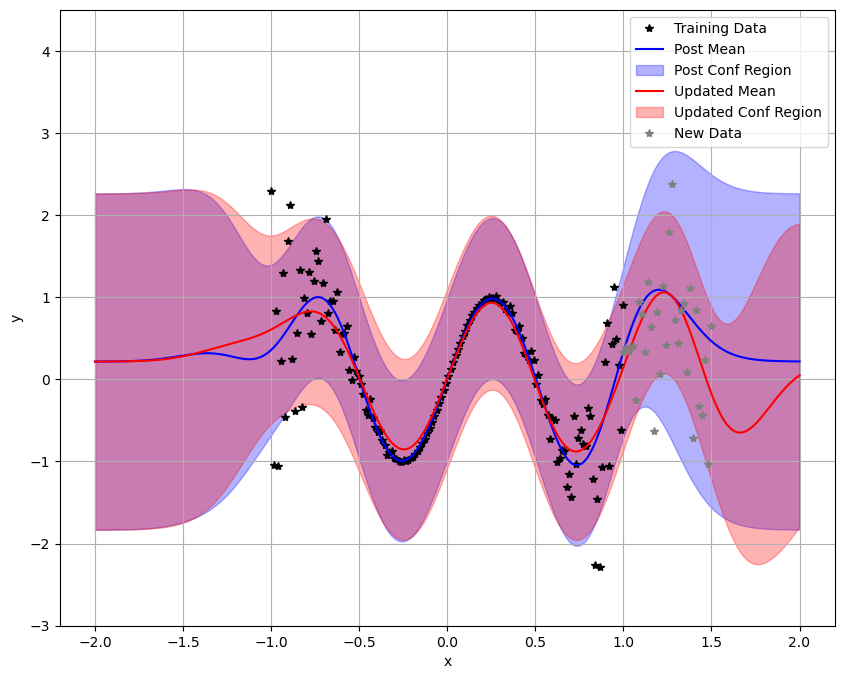

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*', label="Training Data") # data
plt.plot(x_test.numpy(), mean.numpy(), 'b-', label="Post Mean") # posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower.squeeze().numpy(),
                 upper.squeeze().numpy(),
                 alpha=0.3,
                 color="blue",
                 label = "Post Conf Region") # Shade in confidence

plt.plot(x_test.numpy(), mean_updated.numpy(), 'r', label="Updated Mean") # updated posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower_updated.squeeze().numpy(),
                 upper_updated.squeeze().numpy(),
                 alpha=0.3,
                 color="red",
                 label="Updated Conf Region") # Shade in confidence
plt.plot(x_new, y_new, linestyle="None", color="gray", marker="*", label="New Data")

plt.ylim([-3.0, 4.5])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Setup BLL NN

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the PyTorch model class
class BLL_NN(nn.Module):
    def __init__(self, architecture, activation_fn=nn.ReLU):
        super().__init__()
        layers = []
        
        # Initialize Input layer size
        in_size = architecture[0]
        
        # Add hidden layers
        for layer in range(1, len(architecture) - 1):
            out_size = architecture[layer]
            layers.append(nn.Linear(in_size, out_size))
            layers.append(activation_fn())
            in_size = out_size # for next layer 
        
        # Output layer (no activation for the output layer)
        layers.append(nn.Linear(in_size, architecture[-1]))
        
        # Create a sequential model with the layers
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the model.
        """
        return self.network(x)
    
    def get_activations(self, x):
        """
        Method to get intermediate activations before the final output layer.
        """
        activations = []
        for layer in self.network[:-1]:  # Ignore the last output layer
            x = layer(x)
            activations.append(x)
        return activations[-1] # Return the final hidden activations
    
    def get_std(self, x_test, x_train, sig_w=1e0, sig_e=1e0):
        Sigma_E = np.eye(x_train.shape[0]) * 1 / sig_e**2          
        Sigma_W = np.eye(architecture[-2]) * 1 / sig_w**2
        
        a_train = self.get_activations(x_train)
        a_hat = self.get_activations(x_test)
        
        cov = a_hat.detach().numpy() @ np.linalg.inv(a_train.T.detach().numpy() @ Sigma_E @ a_train.detach().numpy() 
                                                     + Sigma_W) @ a_hat.T.detach().numpy()
        std2_nn_raw = np.diag(cov).reshape(x_test.shape)
        std_nn_raw = np.sqrt(std2_nn_raw)
        # err_nn_raw = np.abs(y_hat_nn.detach().numpy() - y_test).reshape(y_test.shape)
        return std_nn_raw

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the architecture and create the model
architecture = [1, 50, 50, 1]
model = BLL_NN(architecture, activation_fn=nn.Tanh)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

## Setup Training Data

In [42]:
# USER Parameters for the sinusoid
freq_sine = 1 # Hz
n_samples = 150

# Create input datasets and sine wave w/ noise variation
x_train = np.linspace(-1.5, 1.5, n_samples)
y_train = np.sin(2 * np.pi * freq_sine * x_train) + np.random.randn(n_samples) * (x_train ** 3)

## Train BLL NN

In [43]:
# Train model
x_train_tens = torch.Tensor(x_train.reshape(-1, 1))
y_train_tens = torch.Tensor(y_train.reshape(-1, 1))
num_epochs = 500

for epoch in range(num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train_tens)
    loss = criterion(y_pred, y_train_tens)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 2.6271393299102783
Epoch 10, Loss: 2.554823160171509
Epoch 20, Loss: 2.545902729034424
Epoch 30, Loss: 2.5301365852355957
Epoch 40, Loss: 2.526233196258545
Epoch 50, Loss: 2.524656057357788
Epoch 60, Loss: 2.523770570755005
Epoch 70, Loss: 2.523249626159668
Epoch 80, Loss: 2.5225131511688232
Epoch 90, Loss: 2.5213463306427
Epoch 100, Loss: 2.5188910961151123
Epoch 110, Loss: 2.5129446983337402
Epoch 120, Loss: 2.4987857341766357
Epoch 130, Loss: 2.471060276031494
Epoch 140, Loss: 2.414109945297241
Epoch 150, Loss: 2.320408582687378
Epoch 160, Loss: 2.2302308082580566
Epoch 170, Loss: 2.179326295852661
Epoch 180, Loss: 2.1584489345550537
Epoch 190, Loss: 2.146904230117798
Epoch 200, Loss: 2.135974884033203
Epoch 210, Loss: 2.12485408782959
Epoch 220, Loss: 2.1136882305145264
Epoch 230, Loss: 2.109212636947632
Epoch 240, Loss: 2.1042404174804688
Epoch 250, Loss: 2.0974459648132324
Epoch 260, Loss: 2.0899152755737305
Epoch 270, Loss: 2.0836522579193115
Epoch 280, Loss: 2.07

## Obtain BLL Predictions

In [44]:
# Setup Test Data
n_test_samples = n_samples * 2
x_test = torch.linspace(-2, 2, n_test_samples).view(-1, 1)

model.eval()
with torch.no_grad():
    y_hat_nn = model(x_test)

std_nn = model.get_std(x_test, x_train_tens)

## Plot BLL Predictions

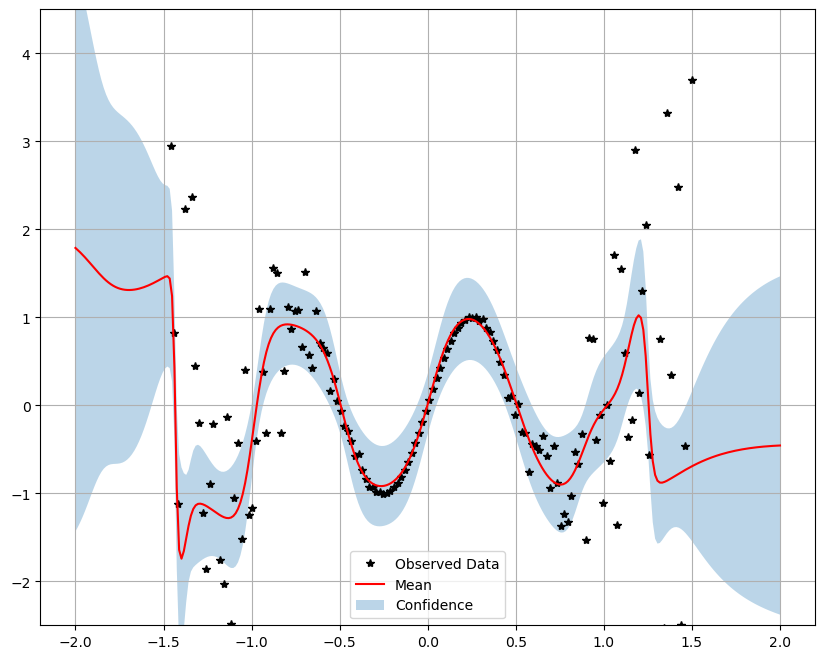

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*')
plt.plot(x_test, y_hat_nn.detach().numpy(), 'r') # Predictive mean 

lower = y_hat_nn.detach().numpy() - 2 * std_nn
upper = y_hat_nn.detach().numpy() + 2 * std_nn

# Shade in confidence 
plt.fill_between(x_test.squeeze(), 
                 lower.squeeze(), 
                 upper.squeeze(), 
                 alpha=0.3)
plt.ylim([-2.5, 4.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()